# Designing and Creating a Database

In this guided project, we will:

* Import data into SQLite
* Design a normalized database schema
* Create tables for our schema
* Insert data into our schema

We will be working with a file of Major League Baseball games from Retrosheet. Retrosheet compiles detailed statistics on baseball games from the 1800s through to today. The main file we will be working from game_log.csv, has been produced by combining 127 separate CSV files from retrosheet, and has been pre-cleaned to remove some inconsistencies. The game log has hundreds of data points on each game which we will normalize into several separate tables using SQL, providing a robust database of game-level statistics.

In addition to the main file, we have also included three 'helper' files, also sourced from Retrosheet:

* park_codes.csv
* person_codes.csv
* team_codes.csv
* appearance_type.csv

These three helper files in some cases contain extra data, but will also make things easier as they will form the basis for three of our normalized tables.

In [1]:
import pandas as pd
import sqlite3

In [2]:
game_log = pd.read_csv('game_log.csv')
park_codes = pd.read_csv('park_codes.csv')
person_codes = pd.read_csv('person_codes.csv')
team_codes = pd.read_csv('team_codes.csv')
appearance_type = pd.read_csv('appearance_type.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (12,13,14,15,19,20,81,82,83,84,85,86,87,88,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration

In [3]:
print('game_log')
print(game_log.columns)
print(game_log.shape)
print('\n')
print('park_codes')
print(park_codes.columns)
print(park_codes.shape)
print('\n')
print('person_codes')
print(person_codes.columns)
print(person_codes.shape)
print('\n')
print('team_codes')
print(team_codes.columns)
print(team_codes.shape)
print('\n')
print('appearance_type')
print(appearance_type.columns)
print(appearance_type.shape)

game_log
Index(['date', 'number_of_game', 'day_of_week', 'v_name', 'v_league',
       'v_game_number', 'h_name', 'h_league', 'h_game_number', 'v_score',
       ...
       'h_player_7_name', 'h_player_7_def_pos', 'h_player_8_id',
       'h_player_8_name', 'h_player_8_def_pos', 'h_player_9_id',
       'h_player_9_name', 'h_player_9_def_pos', 'additional_info',
       'acquisition_info'],
      dtype='object', length=161)
(171907, 161)


park_codes
Index(['park_id', 'name', 'aka', 'city', 'state', 'start', 'end', 'league',
       'notes'],
      dtype='object')
(252, 9)


person_codes
Index(['id', 'last', 'first', 'player_debut', 'mgr_debut', 'coach_debut',
       'ump_debut'],
      dtype='object')
(20494, 7)


team_codes
Index(['team_id', 'league', 'start', 'end', 'city', 'nickname', 'franch_id',
       'seq'],
      dtype='object')
(150, 8)


appearance_type
Index(['appearance_type_id', 'name', 'category'], dtype='object')
(31, 3)


In [4]:
!cat game_log_fields.txt

Field(s)  Meaning
    1     Date in the form "yyyymmdd"
    2     Number of game:
             "0" -- a single game
             "1" -- the first game of a double (or triple) header
                    including seperate admission doubleheaders
             "2" -- the second game of a double (or triple) header
                    including seperate admission doubleheaders
             "3" -- the third game of a triple-header
             "A" -- the first game of a double-header involving 3 teams
             "B" -- the second game of a double-header involving 3 teams
    3     Day of week  ("Sun","Mon","Tue","Wed","Thu","Fri","Sat")
  4-5     Visiting team and league
    6     Visiting team game number
          For this and the home team game number, ties are counted as
          games and suspended games are counted from the starting
          rather than the ending date.
  7-8     Home team and league
    9     Home team game number
10-11     Visiting and home team score (unquoted)


In [5]:
game_log.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,NaN,1,FW1,NaN,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,NaN,1,WS3,NaN,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,NaN,2,RC1,NaN,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,NaN,3,CH1,NaN,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,NaN,2,TRO,NaN,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


In [6]:
park_codes.head()

,park_id,name,aka,city,state,start,end,league,notes
0,ALB01,Riverside Park,NaN,Albany,NY,09/11/1880,05/30/1882,NL,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,NaN,Altoona,PA,04/30/1884,05/31/1884,UA,NaN
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,04/19/1966,NaN,AL,NaN
3,ARL01,Arlington Stadium,NaN,Arlington,TX,04/21/1972,10/03/1993,AL,NaN
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,04/11/1994,NaN,AL,NaN


In [7]:
person_codes.head()

,id,last,first,player_debut,mgr_debut,coach_debut,ump_debut
0,aardd001,Aardsma,David,04/06/2004,NaN,NaN,NaN
1,aaroh101,Aaron,Hank,04/13/1954,NaN,NaN,NaN
2,aarot101,Aaron,Tommie,04/10/1962,NaN,04/06/1979,NaN
3,aased001,Aase,Don,07/26/1977,NaN,NaN,NaN
4,abada001,Abad,Andy,09/10/2001,NaN,NaN,NaN


In [8]:
team_codes.head()

,team_id,league,start,end,city,nickname,franch_id,seq
0,ALT,UA,1884,1884,Altoona,Mountain Cities,ALT,1
1,ARI,NL,1998,0,Arizona,Diamondbacks,ARI,1
2,BFN,NL,1879,1885,Buffalo,Bisons,BFN,1
3,BFP,PL,1890,1890,Buffalo,Bisons,BFP,1
4,BL1,NaN,1872,1874,Baltimore,Canaries,BL1,1


## Importing Data into SQLite

In [9]:
#These are hepler functions that I will use throughout 
#this project for ease of use

DB = "mlb.db"

def run_query(q):
    with sqlite3.connect(DB) as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [10]:
tables = {
    "game_log": game_log,
    "person_codes": person_codes,
    "team_codes": team_codes,
    "park_codes": park_codes,
    'appearance_type': appearance_type
}

with sqlite3.connect(DB) as conn:    
    for name, data in tables.items():
        conn.execute("DROP TABLE IF EXISTS {};".format(name))
        data.to_sql(name,conn,index=False)

In [11]:
show_tables()

,name,type
0,person,table
1,park,table
2,league,table
3,team,table
4,game,table
5,team_appearance,table
6,person_appearance,table
7,game_log,table
8,person_codes,table
9,team_codes,table


In [12]:
#Create Primary Key for the game_log table

c1 = """
ALTER TABLE game_log
ADD COLUMN game_id TEXT;
"""

try:
    run_command(c1)
except:
    pass

c2 = """
UPDATE game_log
SET game_id = date || h_name || number_of_game
WHERE game_id IS NULL; 
"""

run_command(c2)

q = """
SELECT
    game_id,
    date,
    h_name,
    number_of_game
FROM game_log;
"""

run_query(q)

,game_id,date,h_name,number_of_game
0,18710504FW10,18710504,FW1,0
1,18710505WS30,18710505,WS3,0
2,18710506RC10,18710506,RC1,0
3,18710508CH10,18710508,CH1,0
4,18710509TRO0,18710509,TRO,0
5,18710511CL10,18710511,CL1,0
6,18710513CL10,18710513,CL1,0
7,18710513FW10,18710513,FW1,0
8,18710515FW10,18710515,FW1,0
9,18710516BS10,18710516,BS1,0


## Data Normailzation

Throughout each one of the datasets we have imported there are many opportunities for normaliztion to simplify our tables by following normal forms. Here are many of the opportunities identified that we can excute in this project:

* In person_codes, all the debut dates will be able to be reproduced using game log data.
* In team_codes, the start, end and sequence columns will be able to be reproduced using game log data.
* In park_codes, the start and end years will be able to be reproduced using game log data. While technically the state is an attribute of the city, we might not want to have a an incomplete city/state table so we will leave this in.
* There are lots of places in game log where we have a player ID followed by the players name. We will be able to remove this and use the name data in person_codes
* In game_log, all offensive and defensive stats are repeated for the home team and the visiting team. We could break these out and have a table that lists each game twice, one for each team, and cut out this column repetition.
* Similarly, in game_log, we have a listing for 9 players on each team with their positions - we can remove these and have one table that tracks player appearances and their positions.
* We can do a similar thing with the umpires from game_log, instead of listing all four positions as columns, we can put the umpires either in their own table or make one table for players, umpires and managers.
* We have several awards in game_log like winning pitcher and losing pitcher. We can either break these out into their own table, have a table for awards, or combine the awards in with general appearances like the players and umpires.

## Normalized Database Plan

The following schema was planned using DbDesigner.net!

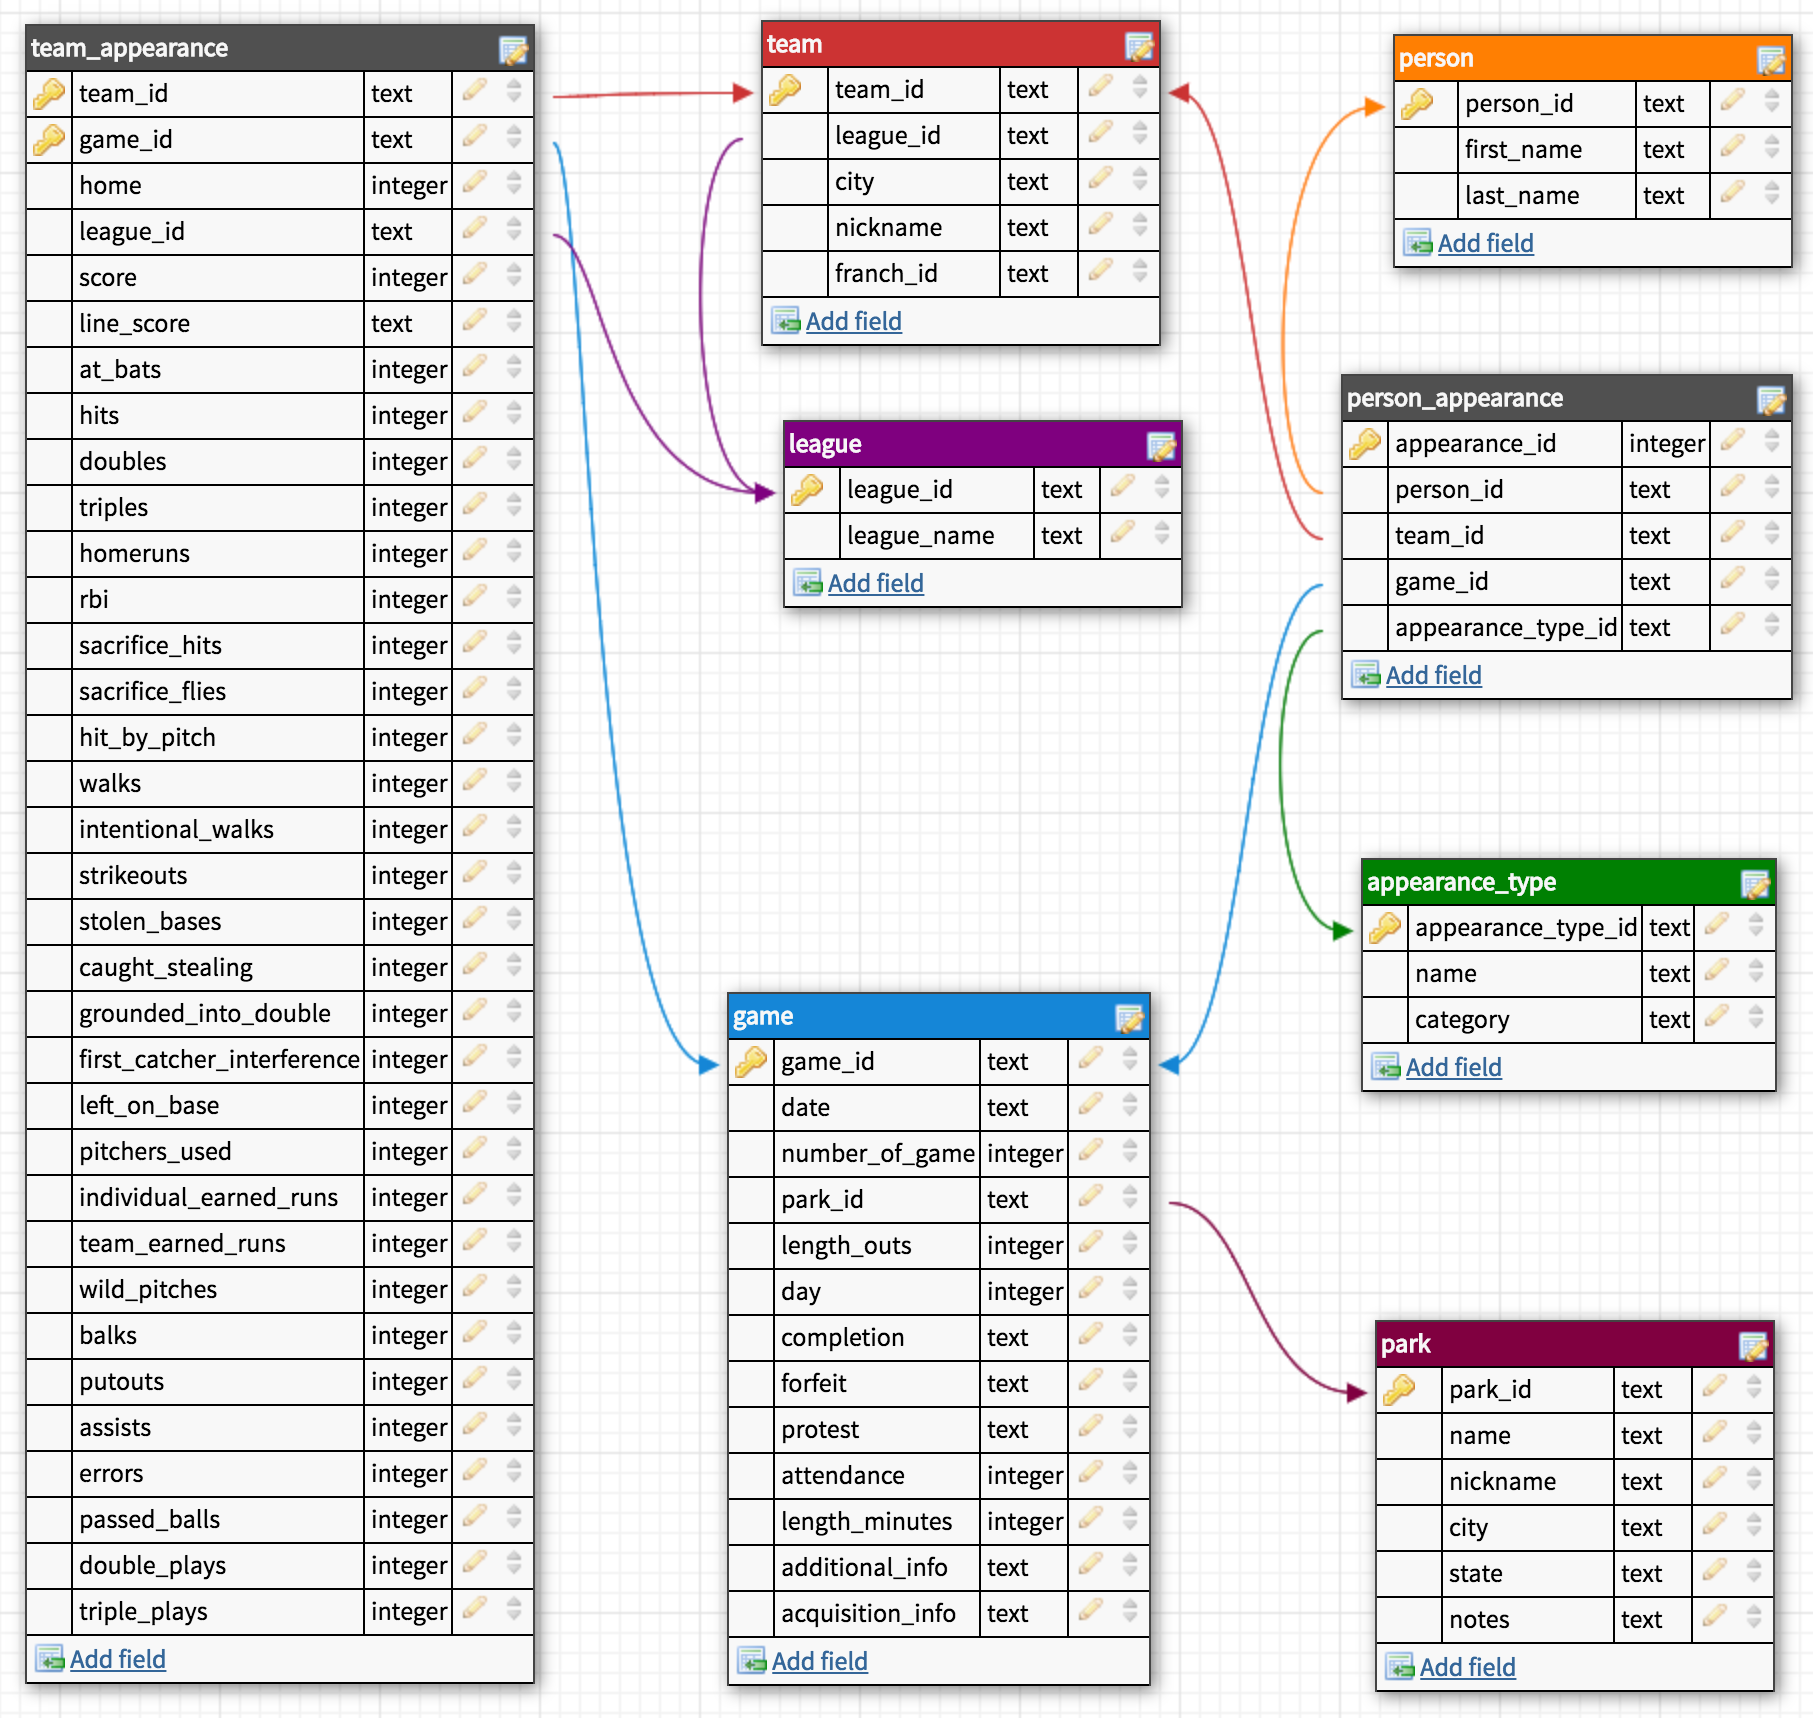

Our database design contains 8 tables, where the team_appearance tables contains a compound primary key and the rest of the tables containing a single primary key.

## Create Databse Tables

In [13]:
#Creating person table

c1 = """
CREATE TABLE IF NOT EXISTS person(
    person_id TEXT,
    first_name TEXT,
    last_name TEXT,
    PRIMARY KEY (person_id));
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO person
SELECT
    id,
    first,
    last
FROM person_codes;
"""

run_command(c2)

q= """
SELECT * FROM person LIMIT 10
"""

run_query(q)

,person_id,first_name,last_name
0,aardd001,David,Aardsma
1,aaroh101,Hank,Aaron
2,aarot101,Tommie,Aaron
3,aased001,Don,Aase
4,abada001,Andy,Abad
5,abadf001,Fernando,Abad
6,abadj101,John,Abadie
7,abbae101,Ed,Abbaticchio
8,abbeb101,Bert,Abbey
9,abbec101,Charlie,Abbey


In [14]:
#Creating person table

c1 = """
CREATE TABLE IF NOT EXISTS park(
    park_id TEXT,
    name TEXT,
    nickname TEXT,
    city TEXT,
    state TEXT,
    notes TEXT,
    PRIMARY KEY (park_id));
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO park
SELECT
    park_id,
    name,
    aka,
    city,
    state,
    notes
FROM park_codes;
"""

run_command(c2)

q= """
SELECT * FROM park LIMIT 10
"""

run_query(q)

,park_id,name,nickname,city,state,notes
0,ALB01,Riverside Park,None,Albany,NY,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,None,Altoona,PA,None
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,None
3,ARL01,Arlington Stadium,None,Arlington,TX,None
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,None
5,ATL01,Atlanta-Fulton County Stadium,None,Atlanta,GA,None
6,ATL02,Turner Field,None,Atlanta,GA,None
7,ATL03,Suntrust Park,None,Atlanta,GA,None
8,BAL01,Madison Avenue Grounds,None,Baltimore,MD,WS3
9,BAL02,Newington Park,None,Baltimore,MD,BL1:1872-74; BL4:1873; BL2: 1882


In [15]:
#Creating league table

c1 = """
CREATE TABLE IF NOT EXISTS league (
    league_id TEXT PRIMARY KEY,
    name TEXT
);
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO league
VALUES
    ("NL", "National League"),
    ("AL", "American League"),
    ("AA", "American Association"),
    ("FL", "Federal League"),
    ("PL", "Players League"),
    ("UA", "Union Association")
;
"""

run_command(c2)

q = """
SELECT * FROM league
"""

run_query(q)

,league_id,name
0,NL,National League
1,AL,American League
2,AA,American Association
3,FL,Federal League
4,PL,Players League
5,UA,Union Association


In [16]:
#Create appearance_type tables

c1 = "DROP TABLE IF EXISTS appearance_type;"

run_command(c1)

c2 = """
CREATE TABLE appearance_type (
    appearance_type_id TEXT PRIMARY KEY,
    name TEXT,
    category TEXT
);
"""
run_command(c2)

with sqlite3.connect('mlb.db') as conn:
    appearance_type.to_sql('appearance_type',
                           conn,
                           index=False,
                           if_exists='append')

q = """
SELECT * FROM appearance_type;
"""

run_query(q)

,appearance_type_id,name,category
0,O1,Batter 1,offense
1,O2,Batter 2,offense
2,O3,Batter 3,offense
3,O4,Batter 4,offense
4,O5,Batter 5,offense
5,O6,Batter 6,offense
6,O7,Batter 7,offense
7,O8,Batter 8,offense
8,O9,Batter 9,offense
9,D1,Pitcher,defense


In [17]:
#Create team table

c1 = """
CREATE TABLE IF NOT EXISTS team (
    team_id TEXT,
    league_id TEXT,
    city TEXT,
    nickname TEXT,
    franch_id TEXT,
    PRIMARY KEY (team_id),
    FOREIGN KEY (league_id) REFERENCES league(league_id)
);
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO team
SELECT
    team_id,
    league,
    city,
    nickname,
    franch_id
FROM team_codes;
"""

run_command(c2)

q = """
SELECT * FROM team
LIMIT 10;
"""

run_query(q)

,team_id,league_id,city,nickname,franch_id
0,ALT,UA,Altoona,Mountain Cities,ALT
1,ARI,NL,Arizona,Diamondbacks,ARI
2,BFN,NL,Buffalo,Bisons,BFN
3,BFP,PL,Buffalo,Bisons,BFP
4,BL1,None,Baltimore,Canaries,BL1
5,BL2,AA,Baltimore,Orioles,BL2
6,BLN,NL,Baltimore,Orioles,BL2
7,BL4,None,Baltimore,Marylands,BL4
8,BLA,AL,Baltimore,Orioles,BLA
9,NYA,AL,New York,Yankees,BLA


In [21]:
#Create game table

c1 = """
CREATE TABLE IF NOT EXISTS game (
    game_id TEXT,
    date TEXT,
    number_of_game INTEGER,
    park_id TEXT,
    length_outs INTEGER,
    day BOOLEAN,
    completion TEXT,
    forefeit TEXT,
    protest TEXT,
    attendance INTEGER,
    legnth_minutes INTEGER,
    additional_info TEXT,
    acquisition_info TEXT,
    PRIMARY KEY (game_id),
    FOREIGN KEY (park_id) REFERENCES park(park_id)
);
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO game
SELECT
    game_id,
    date,
    number_of_game,
    park_id,
    length_outs,
    CASE
        WHEN day_night = "D" THEN 1
        WHEN day_night = "N" THEN 0
        ELSE NULL
        END
        AS day,
    completion,
    forefeit,
    protest,
    attendance,
    length_minutes,
    additional_info,
    acquisition_info
FROM game_log;
"""

run_command(c2)

q = """
SELECT * FROM game
LIMIT 5;
"""

run_query(q)

,game_id,date,number_of_game,park_id,length_outs,day,completion,forefeit,protest,attendance,legnth_minutes,additional_info,acquisition_info
0,18710504FW10,18710504,0,FOR01,54,1,None,None,None,200,120,None,Y
1,18710505WS30,18710505,0,WAS01,54,1,None,None,None,5000,145,HTBF,Y
2,18710506RC10,18710506,0,RCK01,54,1,None,None,None,1000,140,None,Y
3,18710508CH10,18710508,0,CHI01,54,1,None,None,None,5000,150,None,Y
4,18710509TRO0,18710509,0,TRO01,54,1,None,None,None,3250,145,HTBF,Y


In [24]:
#Create team_appearance table

c1 = """
CREATE TABLE IF NOT EXISTS team_appearance (
    team_id TEXT,
    game_id TEXT,
    home BOOLEAN,
    league_id TEXT,
    score INTEGER,
    line_score TEXT,
    at_bats INTEGER,
    hits INTEGER,
    doubles INTEGER,
    triples INTEGER,
    homeruns INTEGER,
    rbi INTEGER,
    sacrifice_hits INTEGER,
    sacrifice_flies INTEGER,
    hit_by_pitch INTEGER,
    walks INTEGER,
    intentional_walks INTEGER,
    strikeouts INTEGER,
    stolen_bases INTEGER,
    caught_stealing INTEGER,
    grounded_into_double INTEGER,
    first_catcher_interference INTEGER,
    left_on_base INTEGER,
    pitchers_used INTEGER,
    individual_earned_runs INTEGER,
    team_earned_runs INTEGER,
    wild_pitches INTEGER,
    balks INTEGER,
    putouts INTEGER,
    assists INTEGER,
    errors INTEGER,
    passed_balls INTEGER,
    double_plays INTEGER,
    triple_plays INTEGER,
    PRIMARY KEY (team_id, game_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id)
);
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO team_appearance
    SELECT
        h_name,
        game_id,
        1 AS home,
        h_league,
        h_score,
        h_line_score,
        h_at_bats,
        h_hits,
        h_doubles,
        h_triples,
        h_homeruns,
        h_rbi,
        h_sacrifice_hits,
        h_sacrifice_flies,
        h_hit_by_pitch,
        h_walks,
        h_intentional_walks,
        h_strikeouts,
        h_stolen_bases,
        h_caught_stealing,
        h_grounded_into_double,
        h_first_catcher_interference,
        h_left_on_base,
        h_pitchers_used,
        h_individual_earned_runs,
        h_team_earned_runs,
        h_wild_pitches,
        h_balks,
        h_putouts,
        h_assists,
        h_errors,
        h_passed_balls,
        h_double_plays,
        h_triple_plays
    FROM game_log

UNION

    SELECT    
        v_name,
        game_id,
        0 AS home,
        v_league,
        v_score,
        v_line_score,
        v_at_bats,
        v_hits,
        v_doubles,
        v_triples,
        v_homeruns,
        v_rbi,
        v_sacrifice_hits,
        v_sacrifice_flies,
        v_hit_by_pitch,
        v_walks,
        v_intentional_walks,
        v_strikeouts,
        v_stolen_bases,
        v_caught_stealing,
        v_grounded_into_double,
        v_first_catcher_interference,
        v_left_on_base,
        v_pitchers_used,
        v_individual_earned_runs,
        v_team_earned_runs,
        v_wild_pitches,
        v_balks,
        v_putouts,
        v_assists,
        v_errors,
        v_passed_balls,
        v_double_plays,
        v_triple_plays
    from game_log;
"""

run_command(c2)

q = """
SELECT * FROM team_appearance
LIMIT 10;
"""

run_query(q)

,team_id,game_id,home,league_id,score,line_score,at_bats,hits,doubles,triples,...,individual_earned_runs,team_earned_runs,wild_pitches,balks,putouts,assists,errors,passed_balls,double_plays,triple_plays
0,ALT,18840417CNU0,0,UA,2,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,ALT,18840418CNU0,0,UA,2,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,ALT,18840419CNU0,0,UA,6,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,ALT,18840424SLU0,0,UA,2,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,ALT,18840426SLU0,0,UA,3,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,ALT,18840427SLU0,0,UA,1,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,ALT,18840428SLU0,0,UA,1,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,ALT,18840430ALT0,1,UA,2,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,ALT,18840502ALT0,1,UA,3,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,ALT,18840503ALT0,1,UA,5,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [27]:
#Create person_appearance table

c1 = """
CREATE TABLE IF NOT EXISTS person_appearance (
    appearance_id INTEGER PRIMARY KEY,
    person_id TEXT,
    team_id TEXT,
    game_id TEXT,
    appearance_type_id,
    FOREIGN KEY (person_id) REFERENCES person(person_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (appearance_type_id) REFERENCES appearance_type(appearance_type_id)
);
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        NULL,
        hp_umpire_id,
        "UHP"
    FROM game_log
    WHERE hp_umpire_id IS NOT NULL    

UNION

    SELECT
        game_id,
        NULL,
        [1b_umpire_id],
        "U1B"
    FROM game_log
    WHERE "1b_umpire_id" IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [2b_umpire_id],
        "U2B"
    FROM game_log
    WHERE [2b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [3b_umpire_id],
        "U3B"
    FROM game_log
    WHERE [3b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        lf_umpire_id,
        "ULF"
    FROM game_log
    WHERE lf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        rf_umpire_id,
        "URF"
    FROM game_log
    WHERE rf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_manager_id,
        "MM"
    FROM game_log
    WHERE v_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_manager_id,
        "MM"
    FROM game_log
    WHERE h_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_pitcher_id,
        "AWP"
    FROM game_log
    WHERE winning_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score < v_score THEN h_name
            ELSE v_name
            END,
        losing_pitcher_id,
        "ALP"
    FROM game_log
    WHERE losing_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        saving_pitcher_id,
        "ASP"
    FROM game_log
    WHERE saving_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_rbi_batter_id,
        "AWB"
    FROM game_log
    WHERE winning_rbi_batter_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE v_starting_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE h_starting_pitcher_id IS NOT NULL;
"""

run_command(c2)

template = """
INSERT INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "O{num}"
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL

UNION

    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "D" || CAST({hv}_player_{num}_def_pos AS INT)
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL;
"""

for hv in ["h","v"]:
    for num in range(1,10):
        query_vars = {
            "hv": hv,
            "num": num
        }
        run_command(template.format(**query_vars))
        

print(run_query("SELECT COUNT(DISTINCT game_id) games_game FROM game"))
print(run_query("SELECT COUNT(DISTINCT game_id) games_person_appearance FROM person_appearance"))

q = """
SELECT
    pa.*,
    at.name,
    at.category
FROM person_appearance pa
INNER JOIN appearance_type at on at.appearance_type_id = pa.appearance_type_id
WHERE PA.game_id = (
                   SELECT max(game_id)
                    FROM person_appearance
                   )
ORDER BY team_id, appearance_type_id
"""

run_query(q)

   games_game
0      171907
   games_person_appearance
0                   171907


,appearance_id,person_id,team_id,game_id,appearance_type_id,name,category
0,1646109,porta901,None,20161002WAS0,U1B,First Base,umpire
1,8362389,porta901,None,20161002WAS0,U1B,First Base,umpire
2,15078669,porta901,None,20161002WAS0,U1B,First Base,umpire
3,21794949,porta901,None,20161002WAS0,U1B,First Base,umpire
4,28511229,porta901,None,20161002WAS0,U1B,First Base,umpire
5,1646108,onorb901,None,20161002WAS0,U2B,Second Base,umpire
6,8362388,onorb901,None,20161002WAS0,U2B,Second Base,umpire
7,15078668,onorb901,None,20161002WAS0,U2B,Second Base,umpire
8,21794948,onorb901,None,20161002WAS0,U2B,Second Base,umpire
9,28511228,onorb901,None,20161002WAS0,U2B,Second Base,umpire


## Remove 4 Original tables

In [28]:
show_tables()

,name,type
0,person,table
1,park,table
2,league,table
3,team,table
4,game,table
5,team_appearance,table
6,person_appearance,table
7,game_log,table
8,person_codes,table
9,team_codes,table


We will have to remove the game_log, park_codes, team_codes, and person_codes tables

In [29]:
tables = [
    "game_log",
    "park_codes",
    "team_codes",
    "person_codes"
]

for t in tables:
    c = '''
    DROP TABLE {}
    '''.format(t)
    
    run_command(c)

show_tables()

,name,type
0,person,table
1,park,table
2,league,table
3,team,table
4,game,table
5,team_appearance,table
6,person_appearance,table
7,appearance_type,table


Now we have the normalized database we designed fully constructed with data imported, primary keys & foerign keys assigned! This is now a fully functioning SQLite database!